# Tracking Beam Center Drift

__Goal:__ Analyze how the center of the data drifts with respect to lab time. To do this, we will average images based on file number and find the center for each group. 

__Note:__ 
* No data processing is done except for applying a mask. 
* Group size can be set manually
* Occasionally the center finding fails and returns (0,0) when this happens the center for that group is replaced with the average value of the centers

## Import necessary Packages

In [28]:
import numpy as np
from math import exp, sqrt, floor
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2

## Define Functions

### Loading Data

In [2]:
def get_data(file_path, shape = False, file_names = False):
    """
    Generates an array of images of TIFF files.
    
    Arguments:
    
    file_path (string) = Path containing the UED TIFF files. Path can be for a singular image or for a folder containing
                        many files. See examples below for example using //*// format style.
    shape (bool, optional) = Boolean expression. If set to True, function returns the shape of the image data array.
    file_names (bool, optional) = Boolean Expression. If set to true, function returns the list of file names.
    
    Returns: data_array, shape (if True), file_names (if True)
    
    numpy array or tuple: 
            If shape = False, file_names = False: Returns numpy array containing data from tiff files as a n x shape x shape (shape refers to the
                                dimensions of the TIFF file, typically 1024 x 1024).
            If shape = True: returns tuple. First element is a numpy array containing data from tiff files as a n x shape x shape
                                (shape refers to the dimensions of the TIFF file, typically 1024 x 1024). Second element is the dimensions
                                of the data array as a tuple.
            If file_names = True: returns tuple containing data array and list with file names.
            
    
    Examples:
    
    file_path = "Desktop/Folder/Data_Analysis/20034291//*//*//ANDOR1_*.tif"
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]]
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]], (220, 1024, 1024)
    
    Notes:
        - All images must be of same dimension. If images of different shapes needed, either group them by shape and run this function for
            each file shape or create it manually by reading files into a numpy array with dtype = object. Be careful as this can lead to 
            later problems
        - Review "*" notation to read in all files of a singular type. Expedites the process.
    
    """
    files = glob.glob(file_path) #read in file name
    if not files:
        FileNotFoundError(f"file_path input does not contain any TIFF files: {file_path}")
    data_array = tf.imread(files) # construct array containing files
    if shape and file_names:
        return data_array, data_array.shape, files
    elif shape:
        return data_array, data_array.shape
    elif file_names:
        return data_array, files
    else:
        return data_array
    
def stagePosition(file_names, idx_start, idx_end, unique_positions = False ):
    """
    Finds the stage position in the string for every file name in the list of all TIFF files. Requires the user to find the
    index of the first digit and last digit of a single file and assumes all files are formatted identically. It uses these indices
    to retrieve the digits from the file names and stores them in a list. All files must have the exact same number of characters before
    the stage position in the name of the file. If this is an issue, group the file names by preceding characters and run this function
    on each list of files.
    
    If unique_positions = False, it returns the stage positions as a numpy array. If unique_positions = True, it returns a tuple
                        containing an array of the stage positions, an array of the unique stage positions, and an array containing
                        the indices of the unique stage positions in the original array.
    Arguments: 
    
    file_names (list containing strings): List of file names
    idxStart (int): the index of the first digit of the stage position in the file name
    idxEnd (int): the index of the last digit of the stage position in the file name
    unique_positions
    
    Returns: stage_pos, uniq_stage (optional), uniq_stage_idx (optional)
    
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    uniq_stage (array): Optional. A numpy array containing the unique stage positions listed in ascending order.
    uniq_stage_idx (array): Optional. A numpy array containing the indices of the unique stage positions in the original input array.
    
    Examples:
    
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    >>> stagePosition(file_names, 9, 11)
        [10. 20. 40. 30. 40.]
    
    >>> stagePosition(file_names, 9, 11, unique_positions = True)
        (array([10., 20., 40., 30., 40.]), array([10., 20., 30., 40.]), array([0, 1, 3, 2]))

    """
    try:
        try:
            stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            stage_pos = np.array(stage_pos)
            if unique_positions == True:
                uniq_stage, uniq_stage_idx = np.unique(stage_pos, return_index = True)
                return stage_pos, uniq_stage, uniq_stage_idx
            else:
                return stage_pos
            return stagePos
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in 
            file_names.""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")

def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

def get_image_details(file_names):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage 
    positions, the file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                string = list(map(str, string[-1].split("-")))
                file_order.append(int(string[1]))
                string = list(map(str, string[-1].split("_")))
                stage_pos.append(float(string[0]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    
    counts = get_counts(data_array)
    
    return data_array, stage_pos, file_order, counts 



### Masking Beam Block

In [3]:
def detectorMask(data_array, hole_center, inner_radius, outer_radius, plot_image = True):
    """
    Takes in a 2d data array and applies a circular (donut shaped) detector mask to it, replacing the masked values with np.nan's.
    Returns the masked, 2d data array.

    Arguments:
    
    data_array (2d np.ndarray): 2d data array to be masked.
    hole_center (tuple): Tuple containing the x and y coordinates of the center of the image, each one of which an int.
    inner_radius (float): Inner radius. Values within the radius of this drawn from the center are masked.
    outer_radius (float): Outer radius of the donut. Values outside the radius of this drawn from the center are masked.
    plot_image (bool, optional): If True, plots the masked image. Default is False.

    Returns:
    ring_data (2d np.ndarray): Data array with the circular detector mask applied.
    """
    if not isinstance(hole_center, tuple) or len(hole_center) != 2:
        raise ValueError("hole_center must be a tuple of length 2 containing the x and y coordinates of the hole center.")
    if not (isinstance(inner_radius, (int, float)) and inner_radius > 0):
        raise ValueError("inner_radius must be a positive float or integer.")
    if not (isinstance(outer_radius, (int, float)) and outer_radius > 0):
        raise ValueError("outer_radius must be a positive float or integer.")
    if inner_radius >= outer_radius:
        raise ValueError("inner_radius must be smaller than outer_radius.")


    hole_cx, hole_cy = hole_center
    x_idx, y_idx = np.meshgrid(np.arange(data_array.shape[2]), np.arange(data_array.shape[1]))
    dist = np.sqrt(((x_idx - hole_cx)**2 + (y_idx-hole_cy)**2))
    mask = np.logical_and(dist<=outer_radius, dist>= inner_radius)
    ring_data = []
    for i in range(len(data_array)):
        data = np.where(mask, data_array[i], np.nan)
        ring_data.append(data)
        
    ring_data = np.array(ring_data)
    if plot_image == True:
        img3 = plt.imshow(ring_data[0])
        plt.colorbar(img3)
    return(ring_data)

    
def mask_hole(I,fit_bor,hole_bor,value_bor,show='yes'):
       
    [X_fit,Y_fit]=np.where((I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]<1.1*value_bor) &
                           (I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]>0.9*value_bor))
    if show=='yes':
        plt.scatter(Y_fit+fit_bor[1][0],X_fit+fit_bor[0][0])
    center_hole,r_hole=fit_circle([X_fit+fit_bor[0][0],Y_fit+fit_bor[1][0]])
    
    mask=np.ones((hole_bor[0][1]-hole_bor[0][0],hole_bor[1][1]-hole_bor[1][0])).astype(float)
    for xi in range(len(mask)):
        for yi in range(len(mask[xi])):
            if (xi-center_hole[0]+hole_bor[0][0])**2 + (yi-center_hole[1]+hole_bor[1][0])**2 <= (r_hole+3)**2:
                mask[xi,yi]=np.nan
    I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]=I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]*mask
    
    return mask,center_hole,r_hole

### Center Finding

In [4]:
def find_beam_center(I,center=[500,500],r=175,printr2='no',recursiontime=0):

    recursiontime+=1
    #up down right left,r away pixles average
    fit_value=np.average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    
    [X_f,Y_f]=np.where((I>0.999*fit_value) & (I<1.001*fit_value))
    
    #plt.figure()
    #plt.scatter(Y_f,X_f)
    #plt.imshow(I)
    a=len(X_f)
    i=0
    #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
    while(i<a):
        ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
        if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
            X_f=np.delete(X_f,i)
            Y_f=np.delete(Y_f,i)
            i-=1
            a-=1
        i+=1
    center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
    if r_new==0:
        return [0,0]
    elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
        #new center pretty close to old center
        return center_new
    elif recursiontime>=10:
        return [0,0]
    else:
        #else: iterate
        return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
def fit_circle(fit_points,printr2='yes'):
    
    #circle function: ax+by+c=-(x^2+y^2)
    
    A=np.empty((len(fit_points[0]),3))
    B=np.empty(len(fit_points[0]))
    
    for i in range(len(fit_points[0])):
        B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
        A[i][0]=fit_points[0][i]
        A[i][1]=fit_points[1][i]
        A[i][2]=1
    
    #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
    #namely A*par=B, least square method
    if np.linalg.det(np.dot(A.T,A)) == 0:
        return [],0
    par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
    #correlation coeff, if not very close to 1(less than 3 nines), be careful
    if printr2=='yes':
        y_ave=np.mean(B)
        r2=np.sum((np.dot(A,par)-y_ave)**2)/np.sum((B-y_ave)**2)
        print(r2)
    
    center_new=[round(-par[0]/2),round(-par[1]/2)]
    r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2)
    
    return center_new,r_new



## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [5]:
#dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320'
dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/Run/20180623_2349'
runPath = "/*/*/ANDOR1_*.tif"


bkg_path = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif'


newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/Run/20180623_2349/*/*/ANDOR1_*.tif
/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif
4161
12


### Plotting Example Image

Load a image to check the signal level: /work/centurion/shared/UED_data/FY18_o-nitrophenol/20180623/Run/20180623_2349/scan029/images-ANDOR1/ANDOR1_Throttle-006-154.6000_0001.tif
Total number of images in the chosen directory is 4161


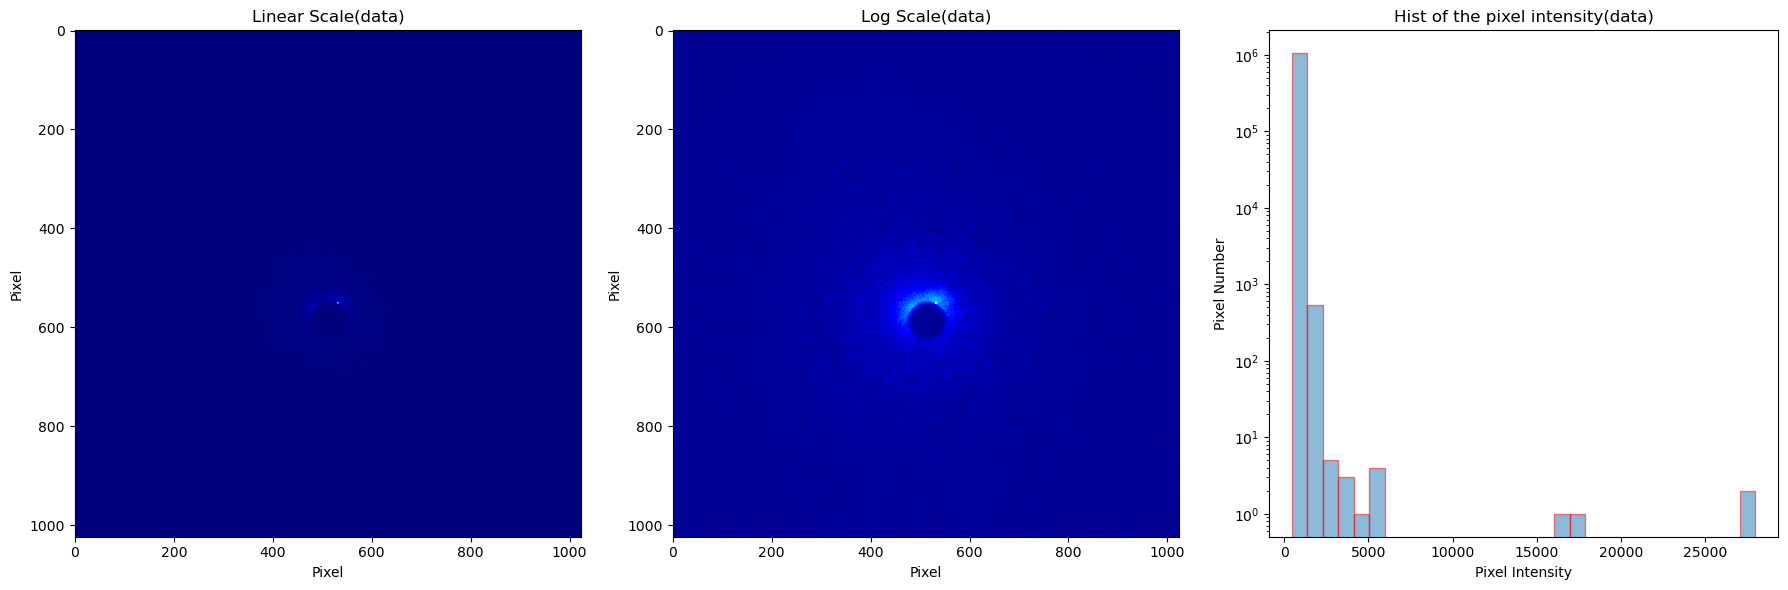

In [6]:
test=tf.imread(files[0]);
bkg_sign='no'
print('Load a image to check the signal level: '+files[0]);
print('Total number of images in the chosen directory is ' + str(len(files)));

# Load or not load the bkg signal
if bkg_sign == 'Yes':
    print('Load background signal');
    data_bkg, _, _, _ = get_image_details(bkg_files) # Load bkg images
    test_bkg = tf.imread(bkg_files[0])
    bkg_dlys_ave = np.nanmean(data_bkg,axis=0) # averaging all the images to optain one image

# Plot a testing figure and check the intensity
plt.figure(figsize=(18,6))

if bkg_sign == 'Yes': # Plot both the data and the background images
    plt.subplot(2,3,1);
    plt.imshow(test,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(2,3,2);
    plt.imshow(np.log(test),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(2,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
    
    plt.subplot(2,3,4);
    plt.imshow(test_bkg,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(bkg)')
    
    plt.subplot(2,3,5);
    plt.imshow(np.log(test_bkg),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(bkg)')
    
    plt.subplot(2,3,6);
    plt.hist(test_bkg.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(bkg)');
    plt.yscale('log')
    
else:
    plt.subplot(1,3,1);
    plt.imshow(test,cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(1,3,2);
    plt.imshow(np.log(test),cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(1,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
plt.tight_layout()
plt.show()

tf.imwrite("Raw_data_ex.tif", test)

### Reading in All Data and Getting Total Counts -- Lauren's Version

In [39]:
%%time

highvalue = 50000 # The highest value of pixel intensity from the histogram plot
print('Load diffraction signal');
test_data, stage_positions, file_numbers, counts = get_image_details(files[:])
counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position

print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))


Load diffraction signal
Image number read:  4161
Stage positions:  37
CPU times: user 5.3 s, sys: 5.89 s, total: 11.2 s
Wall time: 28.3 s


### Visualizing Data Info

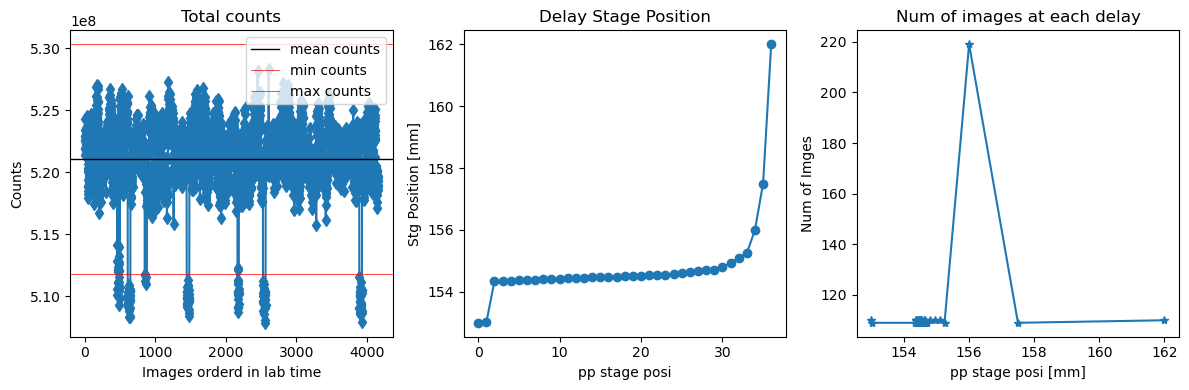

In [40]:
fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

## Averaging Based on Image Number

In [41]:
grp_sz = 50
groups = np.arange(0, len(file_numbers)+1, grp_sz)
data = []
for i in range(len(groups)-1):
    ave_data = np.mean(test_data[groups[i]:groups[i+1]], axis=0)
    print("Averaging group: ", groups[i], "-", groups[i+1])
    data.append(ave_data)
    
data = np.array(data)
print(data.shape)

Averaging group:  0 - 50
Averaging group:  50 - 100
Averaging group:  100 - 150
Averaging group:  150 - 200
Averaging group:  200 - 250
Averaging group:  250 - 300
Averaging group:  300 - 350
Averaging group:  350 - 400
Averaging group:  400 - 450
Averaging group:  450 - 500
Averaging group:  500 - 550
Averaging group:  550 - 600
Averaging group:  600 - 650
Averaging group:  650 - 700
Averaging group:  700 - 750
Averaging group:  750 - 800
Averaging group:  800 - 850
Averaging group:  850 - 900
Averaging group:  900 - 950
Averaging group:  950 - 1000
Averaging group:  1000 - 1050
Averaging group:  1050 - 1100
Averaging group:  1100 - 1150
Averaging group:  1150 - 1200
Averaging group:  1200 - 1250
Averaging group:  1250 - 1300
Averaging group:  1300 - 1350
Averaging group:  1350 - 1400
Averaging group:  1400 - 1450
Averaging group:  1450 - 1500
Averaging group:  1500 - 1550
Averaging group:  1550 - 1600
Averaging group:  1600 - 1650
Averaging group:  1650 - 1700
Averaging group:  1700 

## Masking Beam Block

Uses `opencv.HoughCircles` to find the circular mask on the image.  
We use the function: cv.HoughCircles (image, circles, method, dp, minDist, param1 = 100, param2 = 100, minRadius = 0, maxRadius = 0)

__Parameters:__
 - `image` 8-bit, single-channel, grayscale input image.
 - `circles` output vector of found circles(cv.CV_32FC3 type). Each vector is encoded as a 3-element floating-point vector (x,y,radius) .
 - `method` detection method(see cv.HoughModes). Currently, the only implemented method is HOUGH_GRADIENT
 - `dp` inverse ratio of the accumulator resolution to the image resolution. For example, if dp = 1 , the accumulator has the same resolution as the input image. If dp = 2 , the accumulator has half as big width and height.
 - `minDist` minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
 - `param1` first method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
 - `param2` second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
 - `minRadiu` minimum circle radius.
 - `maxRadius` maximum circle radius.

__Note:__ only works after averaging for each stage position. Too large of data sets causes jupyter to crash. Will trouble shoot this later...

### Find Mask Location

In [42]:
# (1) Hole mask: Define mask of the hole
data_ave_raw = np.mean(data,axis=0); # Mean data of all the images
data_ave     = np.copy(data_ave_raw) #[200:900,200:900]
image_array  = np.log(data_ave)/np.nanmax(np.log(data_ave))
image_array  *=255
im = Image.fromarray(image_array)
im = im.convert('L')
im = np.array(im)

# Mask hole and Finding the diffraction center
hole = np.squeeze(cv2.HoughCircles(im, cv2.HOUGH_GRADIENT_ALT, 1.5, 32, param1=50, param2=0.9, minRadius=30, maxRadius=60))
mask = np.ones((1024,1024)) # Hole mask
y_m,x_m = np.ogrid[:1024,:1024];
mask[((x_m-hole[0])**2 + (y_m-hole[1])**2 <= (hole[2]+5)**2)] = np.nan;# Create a circular mask filled with nans inside the circle
print('The hole center at ' + str(hole[0:2]) + ' with radius ' + str(hole[2:3]));
#stage_ave = stage_ave*mask
#good_data = good_data*mask

The hole center at [514.5 589.5] with radius [37.965946]


### Apply Mask

(514.5, 589.5)
37.965946197509766
(83, 1024, 1024)


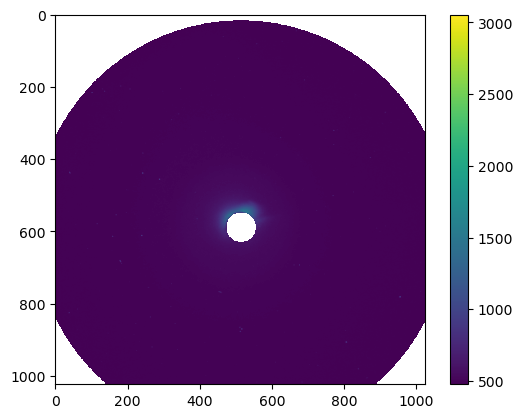

In [43]:
#hole_center = (477.0, 465.0)
hole_center = hole[0], hole[1]
print(hole_center)
inner_radius = float(hole[2])
print(inner_radius)
outer_radius = 575
data_ave_raw = np.mean((data),axis=0); 
ring_mask_data = detectorMask(data, hole_center, inner_radius, outer_radius, plot_image = True)
ring_mask_ave = np.mean(ring_mask_data, axis = 0)
print(ring_mask_data.shape)

data = ring_mask_data

## Finding Diffraction Center

In [47]:
%%time

x_centers = []
y_centers = []
for i in range(len(data)):
    center = find_beam_center(data[i],center=[570,500],r=150)
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%10==0:
        print('Found center of ' + str(center)+' of group ' + str(i))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [572, 496] of group 0
Found center of [573, 492] of group 10
Found center of [573, 493] of group 20
Found center of [573, 489] of group 30
Found center of [573, 494] of group 40
Found center of [572, 489] of group 50
Found center of [573, 493] of group 60
Found center of [572, 489] of group 70
Found center of [571, 493] of group 80
Averaged ctr is (571.25, 491.2236842105263)
CPU times: user 13.3 s, sys: 13.7 s, total: 26.9 s
Wall time: 11.2 s


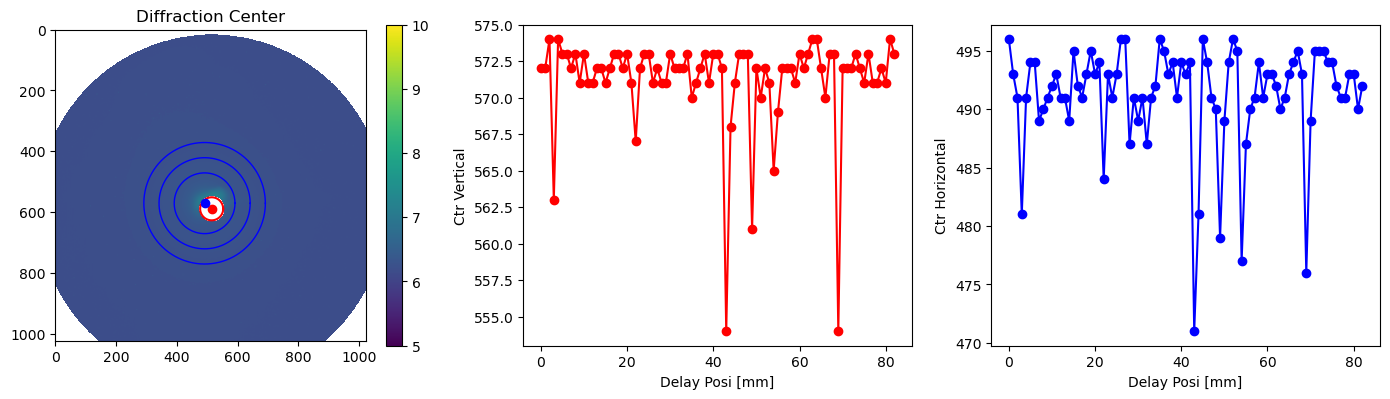

In [48]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(np.mean(data, axis=0)));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or',center_ave[1],center_ave[0],'ob');
for i in range(3):
    x = np.cos(theta)*(i+2)*50+center_ave[1];
    y = np.sin(theta)*(i+2)*50+center_ave[0];
    plt.plot(x,y,linewidth=1,color='b');
plt.clim([5,10]);
plt.title('Diffraction Center')

plt.subplot(1,3,2)
plt.plot(centers[0],'-or');
plt.xlabel('Delay Posi [mm]');
plt.ylabel('Ctr Vertical');

plt.subplot(1,3,3)
plt.plot(centers[1],'-ob');
plt.xlabel('Delay Posi [mm]');
plt.ylabel('Ctr Horizontal');

plt.tight_layout()
plt.show();